In [1]:
!pip install tensorflow_text
!pip install tensorflow_hub

In [2]:
import os
import re
import numpy as np
import string
import camel_tools
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import spacy
import tensorflow as tf
import tensorflow_text as text  
import tensorflow_hub as hub
import h5py

from camel_tools.tokenizers.word import simple_word_tokenize

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder  
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.datasets import load_files
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


from keras import preprocessing
from keras import backend as K
from preprocess.keras_preprocessing.text import Tokenizer

from tqdm import tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Bidirectional, MaxPool1D, MaxPool2D, Flatten, Input, Embedding, concatenate,LSTM,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LearningRateScheduler,TerminateOnNaN,ReduceLROnPlateau,EarlyStopping



Using TensorFlow backend.


# NLP - Assignment 1

## Adam Zebrowski - R00183247

**Notes:**
Please note the following assumptions:
 - data for the notebook is in './data' folder
 - Camel tools are installed and configured

Execution Environment: This notebook has been executed in Microsoft Azure ML Compute with Python 3.6 and TF 2.3.1

In [3]:
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print('Name:', gpu.name, '  Type:', gpu.device_type)

2.3.1
Name: /physical_device:GPU:0   Type: GPU
Name: /physical_device:GPU:1   Type: GPU


In [4]:


train_file = './data/MADAR-Corpus-26-train.tsv'
dev_file = './data/MADAR-Corpus-26-dev.tsv'
gold_file = './data/MADAR-Corpus-26-dev.GOLD'
pred_file = './data/MADAR-Corpus-26-dev-{}.PRED'
#List of predition files for MADAR-DID-Scorer
file_list = []

Read the corpus file and extract:
 - sentences
 - dialects

In [5]:
#Read the MADAR file
def read_madar(file_name):
    sentence, label, rows= [],[], []
    with open(file_name, newline = '', encoding='utf8') as tsv: 
        print(file_name)
        madar_list=[x.strip().split('\t') for x in tsv]
    for row in madar_list:
        #save the array of sentence, dialect
        rows.append([row[0], row[1]]) 
        # save sentenceence
        sentence.append(row[0]) 
        # related dialect 
        label.append(row[1]) 
    return sentence, label, rows

In [6]:
def store_set(labels,file):
    with open(file, 'w') as write_file:
        [write_file.write(label + '\n') for label in labels]

In [7]:
def execute_evaluation(instance_file):
    !python './MADAR-DID-Scorer.py' $gold_file $instance_file

In [8]:
#Read train and test
sentences, dialects, rows = read_madar(train_file)
sentences_test, dialects_test, rows_test = read_madar(dev_file)
#Store the test labels
store_set(dialects_test, gold_file)
#Store all dialects that are present in the set
target_names = set(dialects)
print(set(dialects))

./data/MADAR-Corpus-26-train.tsv
./data/MADAR-Corpus-26-dev.tsv
{'ALG', 'BAG', 'BEI', 'FES', 'MOS', 'RAB', 'DAM', 'SFX', 'JED', 'MSA', 'BAS', 'KHA', 'DOH', 'JER', 'ASW', 'MUS', 'RIY', 'TUN', 'CAI', 'ALE', 'SAN', 'SAL', 'BEN', 'TRI', 'ALX', 'AMM'}


## Step1 (30%) : Data preprocessing

Download the Training and Development Data Canvas. And pre-process the dataset, i.e.
cleaning, tokenization, etc.
You can find an Arabic text tokenizer (Farasa) within the Project_1 folder.
You can, also, use Camel Tools (already installed in C127 machines).
https://github.com/CAMeL-Lab/camel_tools

In [9]:
#Define Emojis
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
#Define Emoticons
emoticons_str = r'''
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose 
        [D\)\]\(\]/\\OpP] # Mouth
    )'''
#Define noise chaaracters
regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)',  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and 
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]
#Define Arabic diacritics
arabic_diacritics = re.compile(''' ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         ''', re.VERBOSE)


In [10]:
#Removing accented letters, diacritics and variations, 
# although I am not Arabic speaker...
def normalize_arabic(text):
    text = remove_diacritics(text)
    text = re.sub('[إأآا]', 'ا', text)
    text = re.sub('ى', 'ي', text)
    text = re.sub('ؤ', 'ء', text)
    text = re.sub('ئ', 'ء', text)
    text = re.sub('ة', 'ه', text)
    text = re.sub('گ', 'ك', text)
    return text

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


#Remove noise
def strip_emoji(text):
    return RE_EMOJI.sub(r'', text)

def remove_punctuations(text):
    punctuations = '!'#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~،؟'
    return ''.join(ch for ch in text if ch not in punctuations)

def remove_digits(text):
    remove_digits = str.maketrans('', '', string.digits)
    res = text.translate(remove_digits)
    return res

In [11]:
#Perform data cleaning based on the above
#Tokenisation is performed as well based on Camel Tools
def clean(corpus):
    new_corpus = []
    tokenised_corpus = []
    for sentence, dialect in corpus:
        clean_text = remove_punctuations(remove_punctuations(sentence))
        clean_text = normalize_arabic(clean_text)
        clean_text = remove_diacritics(clean_text)
        clean_text = remove_digits(clean_text)
        clean_text = strip_emoji(clean_text)
        tokenised_text = camel_tools.tokenizers.word.simple_word_tokenize(clean_text)
        new_corpus.append([clean_text, dialect])
        [tokenised_corpus.append([token, dialect]) for token in tokenised_text]
    return new_corpus, tokenised_corpus

In [12]:
pre_processed_corpus, tokenised_corpus = clean(rows)
pre_processed_corpus_test, tokenised_corpus_test = clean(rows_test)

## Step2 (70%): System implementation
Your task is to implement and compare three different text classification methods as follows.


In [13]:
#Function to visualise the output from model run
def visualise_output(history):
    
    print('\n')
    print('Min Val Loss: ', min(history.history['val_loss']))
    print('Max Val Accuracy: ', max(history.history['val_accuracy']))
    print('\n')
    
    
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
   
    plt.title('Training Loss and Accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch #')
    plt.legend(['train loss', 'val loss', 'train acc', 'val acc'], loc='upper right')
    plt.show()

In [14]:
#Early stopping attributes
reduce_lr1 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=5,mode='max',verbose=1)
early_stopping1 = EarlyStopping(monitor='val_accuracy', min_delta=0.02, patience=15, verbose=1, mode='max')

'''
Main model execution function
It takes the following parameters:
    1. a model
    2. an augmentation generator
    3. optional model name to name the checkpoint files
It will fit the model and checkpoint the improved weights to the file
This function will produce 1 weights file per model, if multiple are required the fname varaible needs
to be swapped for the commented one
'''
def execute_model(model, x, y, x_cv, y_cv, modelName = 'model1', reduce_lr = reduce_lr1, early_stopping = early_stopping1):
    
    fname ='data/' + modelName + '_weights.hdf5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(fname, monitor='val_accuracy', mode='max', save_best_only=True, 
                                                    verbose=0)
    
    h = model.fit(x = x,y = y,batch_size=256, epochs=100, validation_data=(x_cv,y_cv),
                     shuffle=True, callbacks =[checkpoint, reduce_lr, early_stopping])
       
    
    visualise_output(h)
    return min(h.history['val_loss']), max(h.history['val_accuracy'])

In [15]:
'''
Helper function to load previously saved model weights
This function assumes that the models are saved in 'data' folder
and each file is named with the following convention:
    modelName_weights.hdf5
'''
def load_model(model, name):
    path = 'data/{}_weights.hdf5'.format(name)
    model.load_weights(path)
    return model

In [16]:
df_original = pd.DataFrame(pre_processed_corpus,columns = ['sentence','dialect'])
df_test_original = pd.DataFrame(pre_processed_corpus_test,columns = ['sentence','dialect'])

#Keeping unmodified DF
df = df_original.copy()
df_test = df_test_original.copy()

### 1- Feature-Based Classification for Dialectal Arabic (20%)
Use and compare two different feature-based classification methods (classical Machine
Learning techniques) in order to implement your Arabic dialect identification system.

Your models should apply various n-gram features as follows:

-  Word-gram features with uni-gram, bi-gram and tri-gram;
- Character-gram features with/without word boundary consideration, from bi-gram and up to 5-gram.

In [17]:
df.info()
le = LabelEncoder()
target = le.fit_transform(df['dialect'])
target_test = le.fit_transform(df_test['dialect'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41600 entries, 0 to 41599
Data columns (total 2 columns):
sentence    41600 non-null object
dialect     41600 non-null object
dtypes: object(2)
memory usage: 650.1+ KB


In [18]:
df.head()

,sentence,dialect
0,هناك ، امام بيانات الساءح تماما .,MSA
1,لم اسمع بهذا العنوان من قبل بالقرب من هنا .,MSA
2,استمر في السير في هذا الطريق حتي تجد صيدليه .,MSA
3,كم تكلفه الافطار ؟,MSA
4,كيف استطيع مساعدتك ؟,MSA


In [19]:
le.classes_

array(['ALE', 'ALG', 'ALX', 'AMM', 'ASW', 'BAG', 'BAS', 'BEI', 'BEN',
       'CAI', 'DAM', 'DOH', 'FES', 'JED', 'JER', 'KHA', 'MOS', 'MSA',
       'MUS', 'RAB', 'RIY', 'SAL', 'SAN', 'SFX', 'TRI', 'TUN'],
      dtype=object)

In [20]:
df['dialect'] = target
df_test['dialect'] = target_test
print(df.head())

                                        sentence  dialect
0              هناك ، امام بيانات الساءح تماما .       17
1    لم اسمع بهذا العنوان من قبل بالقرب من هنا .       17
2  استمر في السير في هذا الطريق حتي تجد صيدليه .       17
3                             كم تكلفه الافطار ؟       17
4                           كيف استطيع مساعدتك ؟       17


In [21]:
#X_train, X_cv = train_test_split(df, test_size=0.20, stratify=df['dialect'],shuffle=True)
X_train = df
X_cv = df_test

In [22]:
print(X_train.shape)
print(X_cv.shape)

(41600, 2)
(5200, 2)


In [23]:
x_t = np.array(X_train)
print(x_t)


[['هناك ، امام بيانات الساءح تماما .' 17]
 ['لم اسمع بهذا العنوان من قبل بالقرب من هنا .' 17]
 ['استمر في السير في هذا الطريق حتي تجد صيدليه .' 17]
 ...
 ['من وين خاطمين حني توا ؟' 24]
 ['زوز كبار و عيل تلاته سنين .' 24]
 ['في حمام في المحطه .' 24]]


In [24]:
def score_prediction(pred, y_tst):
    print('Predictions using test data: ')
    score = metrics.accuracy_score(y_tst, pred)
    print('Prediction accuracy:   %0.3f' % score)
    print('classification report:')
    print(metrics.classification_report(y_tst, pred,target_names=target_names))
    print('confusion matrix:')
    print(metrics.confusion_matrix(y_tst, pred))

In [25]:
def evaluate(pred, name, description):
    #Reconstructing the actual labels and storing for further validation with 
    #MADAR script
    reconstructed_labels = ([le.classes_[c] for c in pred])
    instance_file = pred_file.format(name)
    store_set(reconstructed_labels, instance_file)
    file_list.append([instance_file, description])
    #Execute Madar script
    print('Evaluation (Task 4):\n')
    execute_evaluation(instance_file)

In [26]:
def gridsearch_knn(x_tr,y_tr, x_tst, y_tst):
    
    n_neighbors = [3, 15, 25, 51,101,151,201,301]
    clf = KNeighborsClassifier( )
    parameters = {'n_neighbors':[3, 15, 25, 51,101,151,201,301]}
    clf = GridSearchCV(clf, parameters, cv=3, scoring='f1_micro',n_jobs=-1,return_train_score=True,verbose=1)
    clf.fit(x_tr,y_tr)
    print('best hyperpameter is : ',clf.best_params_)
    print('best f1 score is : ',clf.best_score_)


    train_f1= clf.cv_results_['mean_train_score']
    train_f1_std= clf.cv_results_['std_train_score']

    cv_f1 = clf.cv_results_['mean_test_score'] 
    cv_f1_std= clf.cv_results_['std_test_score']

    plt.plot(n_neighbors,train_f1, label='Train F1')
          # Reference: this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(n_neighbors,train_f1 - train_f1_std,train_f1 + train_f1_std,alpha=0.2,color='darkblue')

    plt.plot(n_neighbors, cv_f1, label='CV F1')
          # Reference: this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(n_neighbors,cv_f1 - cv_f1_std,cv_f1 + cv_f1_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel('n_neighbors: hyperparameter')
    plt.ylabel('F1')
    plt.title('ERROR PLOTS')
    plt.grid(color='grey')
    plt.show()
    pred = clf.predict(x_tst)
    score_prediction(pred, y_tst)
    return pred



In [27]:
def gridsearch_NB(x_tr, y_tr, x_tst, y_tst):
    alpha = [0.001,0.01,0.1,1,3, 5, 10, 15, 21, 31, 41]
    clf = MultinomialNB(fit_prior = False)
    parameters = {'alpha':[0.001,0.01,0.1,1,3, 5, 10, 15, 21, 31, 41]}
    clf = GridSearchCV(clf, parameters, cv=3, scoring='f1_micro',n_jobs=-1,return_train_score=True)
    clf.fit(x_tr,y_tr)
    
    print('best hyperpameter is : ',clf.best_params_)
    print('best f1 score is : ',clf.best_score_)


    train_f1= clf.cv_results_['mean_train_score']
    train_f1_std= clf.cv_results_['std_train_score']
    cv_f1 = clf.cv_results_['mean_test_score'] 
    cv_f1_std= clf.cv_results_['std_test_score']

    plt.plot(alpha,train_f1, label='Train F1')
          # Reference: this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(alpha,train_f1 - train_f1_std,train_f1 + train_f1_std,alpha=0.2,color='darkblue')

    plt.plot(alpha, cv_f1, label='CV F1')
          # Reference: this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(alpha,cv_f1 - cv_f1_std,cv_f1 + cv_f1_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel('alpha: hyperparameter')
    plt.ylabel('F1')
    plt.title('ERROR PLOTS')
    plt.grid(color='grey')
    plt.show()
    
    pred = clf.predict(x_tst)
    score_prediction(pred, y_tst)
    
    return pred

Word-gram features with uni-gram, bi-gram and tri-gram

In [28]:

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,tokenizer=simple_word_tokenize,ngram_range =(1,3))

vectorizer.fit(X_train['sentence'])

X_train_tfidf = vectorizer.transform(X_train['sentence'])
X_cv_tfidf = vectorizer.transform(X_cv['sentence'])

print('After vectorizations')
print(X_train_tfidf.shape, X_train['dialect'].shape)
print(X_cv_tfidf.shape, X_cv['dialect'].shape)


After vectorizations
(41600, 275343) (41600,)
(5200, 275343) (5200,)


Character-gram features without word boundary consideration, from bi-gram and up to 5-gram.

In [29]:

vectorizer2 = TfidfVectorizer(sublinear_tf=True, max_df=0.5,ngram_range =(2,5),analyzer = 'char')

vectorizer2.fit(X_train['sentence'])

X_train_tfidf_char = vectorizer2.transform(X_train['sentence'])
X_cv_tfidf_char = vectorizer2.transform(X_cv['sentence'])



print('After vectorizations')
print(X_train_tfidf_char.shape, X_train['dialect'].shape)
print(X_cv_tfidf_char.shape, X_cv['dialect'].shape)


#print(vectorizer2.get_feature_names())

After vectorizations
(41600, 201424) (41600,)
(5200, 201424) (5200,)


Character-gram features with word boundary consideration, from bi-gram and up to 5-gram.

In [30]:
vectorizer3 = TfidfVectorizer(sublinear_tf=True, max_df=0.5,ngram_range =(2,5),analyzer = 'char_wb')
vectorizer3.fit(X_train['sentence'])

X_train_tfidf_char_wb = vectorizer3.transform(X_train['sentence'])
X_cv_tfidf_char_wb = vectorizer3.transform(X_cv['sentence'])

print('After vectorizations')
print(X_train_tfidf_char_wb.shape, X_train['dialect'].shape)
print(X_cv_tfidf_char_wb.shape, X_cv['dialect'].shape)


After vectorizations
(41600, 88753) (41600,)
(5200, 88753) (5200,)


#### 2.1.1 KNN

KNN: Word-gram features with uni-gram, bi-gram and tri-gram

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


best hyperpameter is :  {'n_neighbors': 101}
best f1 score is :  0.41346153846153844


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.3min finished


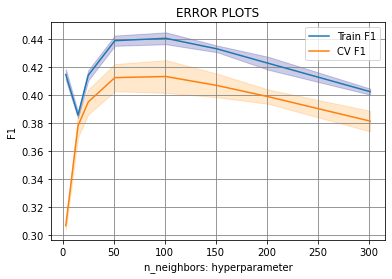

Predictions using test data: 
Prediction accuracy:   0.475
classification report:
              precision    recall  f1-score   support

         ALG       0.53      0.55      0.54       200
         BAG       0.49      0.64      0.55       200
         BEI       0.38      0.41      0.40       200
         FES       0.30      0.43      0.36       200
         MOS       0.37      0.56      0.44       200
         RAB       0.53      0.53      0.53       200
         DAM       0.55      0.47      0.51       200
         SFX       0.71      0.48      0.58       200
         JED       0.54      0.49      0.52       200
         MSA       0.45      0.26      0.32       200
         BAS       0.44      0.38      0.40       200
         KHA       0.46      0.46      0.46       200
         DOH       0.65      0.57      0.61       200
         JER       0.33      0.45      0.38       200
         ASW       0.30      0.54      0.38       200
         MUS       0.46      0.57      0.51       200

In [31]:
pred = gridsearch_knn(X_train_tfidf, X_train['dialect'], X_cv_tfidf, X_cv['dialect'] )

In [32]:
evaluate(pred, 'KNN-1', 'KNN: Word-gram features with uni-gram, bi-gram and tri-gram')

Evaluation (Task 4):


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 49.42 %
MACRO AVERAGE RECALL SCORE: 47.48 %
MACRO AVERAGE F1 SCORE: 47.53 %
OVERALL ACCURACY: 47.48 %



KNN: Character-gram features without word boundary consideration, from bi-gram and up to 5-gram.

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


best hyperpameter is :  {'n_neighbors': 151}
best f1 score is :  0.41139423076923076


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.0min finished


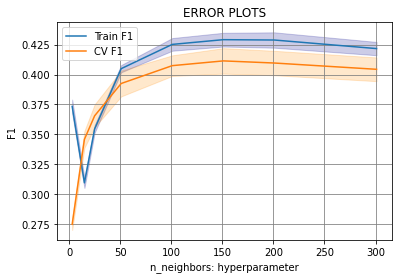

Predictions using test data: 
Prediction accuracy:   0.455
classification report:
              precision    recall  f1-score   support

         ALG       0.50      0.47      0.48       200
         BAG       0.46      0.67      0.55       200
         BEI       0.37      0.43      0.40       200
         FES       0.22      0.37      0.28       200
         MOS       0.39      0.57      0.46       200
         RAB       0.54      0.45      0.49       200
         DAM       0.54      0.42      0.47       200
         SFX       0.65      0.48      0.55       200
         JED       0.42      0.54      0.47       200
         MSA       0.31      0.18      0.23       200
         BAS       0.43      0.38      0.40       200
         KHA       0.41      0.44      0.42       200
         DOH       0.55      0.64      0.59       200
         JER       0.37      0.35      0.36       200
         ASW       0.29      0.46      0.36       200
         MUS       0.44      0.56      0.49       200

In [33]:
pred = gridsearch_knn(X_train_tfidf_char, X_train['dialect'], X_cv_tfidf_char, X_cv['dialect'] )

In [34]:
evaluate(pred, 'KNN-2', 'KNN: Character-gram features without word boundary consideration, from bi-gram and up to 5-gram')

Evaluation (Task 4):


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 47.99 %
MACRO AVERAGE RECALL SCORE: 45.50 %
MACRO AVERAGE F1 SCORE: 45.39 %
OVERALL ACCURACY: 45.50 %



KNN: Character-gram features with word boundary consideration, from bi-gram and up to 5-gram.

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


best hyperpameter is :  {'n_neighbors': 151}
best f1 score is :  0.4128605769230769


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.0min finished


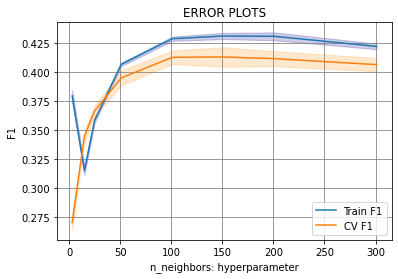

Predictions using test data: 
Prediction accuracy:   0.463
classification report:
              precision    recall  f1-score   support

         ALG       0.44      0.52      0.47       200
         BAG       0.51      0.62      0.56       200
         BEI       0.35      0.41      0.38       200
         FES       0.25      0.38      0.30       200
         MOS       0.33      0.47      0.39       200
         RAB       0.56      0.48      0.52       200
         DAM       0.48      0.44      0.46       200
         SFX       0.56      0.47      0.51       200
         JED       0.40      0.53      0.45       200
         MSA       0.32      0.18      0.23       200
         BAS       0.45      0.39      0.42       200
         KHA       0.42      0.42      0.42       200
         DOH       0.61      0.55      0.58       200
         JER       0.34      0.45      0.39       200
         ASW       0.37      0.44      0.40       200
         MUS       0.41      0.59      0.48       200

In [35]:
pred = gridsearch_knn(X_train_tfidf_char_wb, X_train['dialect'], X_cv_tfidf_char_wb, X_cv['dialect'])

In [36]:
evaluate(pred, 'KNN-3', 'KNN: Character-gram features with word boundary consideration, from bi-gram and up to 5-gram')

Evaluation (Task 4):


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 48.90 %
MACRO AVERAGE RECALL SCORE: 46.29 %
MACRO AVERAGE F1 SCORE: 46.63 %
OVERALL ACCURACY: 46.29 %



#### 2.1.2 Naive Bayes

NB: Word-gram features with uni-gram, bi-gram and tri-gram

best hyperpameter is :  {'alpha': 0.1}
best f1 score is :  0.527860576923077


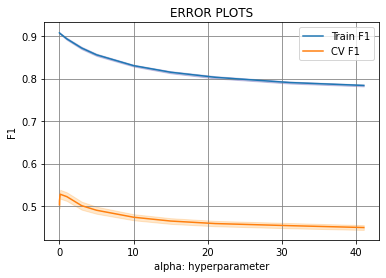

Predictions using test data: 
Prediction accuracy:   0.584
classification report:
              precision    recall  f1-score   support

         ALG       0.59      0.54      0.56       200
         BAG       0.69      0.74      0.72       200
         BEI       0.48      0.47      0.47       200
         FES       0.43      0.50      0.46       200
         MOS       0.47      0.61      0.53       200
         RAB       0.68      0.58      0.63       200
         DAM       0.62      0.62      0.62       200
         SFX       0.74      0.56      0.64       200
         JED       0.64      0.64      0.64       200
         MSA       0.52      0.38      0.44       200
         BAS       0.55      0.49      0.52       200
         KHA       0.53      0.55      0.54       200
         DOH       0.68      0.66      0.67       200
         JER       0.54      0.56      0.55       200
         ASW       0.42      0.55      0.48       200
         MUS       0.51      0.66      0.57       200

In [37]:
pred = gridsearch_NB(X_train_tfidf, X_train['dialect'], X_cv_tfidf, X_cv['dialect'])

In [38]:
evaluate(pred, 'NB-1', 'NB: Word-gram features with uni-gram, bi-gram and tri-gram')

Evaluation (Task 4):


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 59.11 %
MACRO AVERAGE RECALL SCORE: 58.38 %
MACRO AVERAGE F1 SCORE: 58.43 %
OVERALL ACCURACY: 58.38 %



NB: Character-gram features without word boundary consideration, from bi-gram and up to 5-gram.

best hyperpameter is :  {'alpha': 0.1}
best f1 score is :  0.5254086538461539


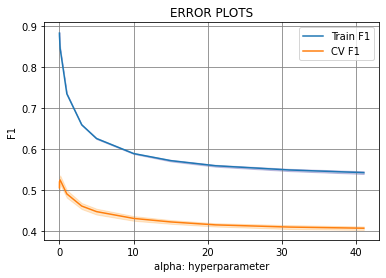

Predictions using test data: 
Prediction accuracy:   0.595
classification report:
              precision    recall  f1-score   support

         ALG       0.67      0.55      0.60       200
         BAG       0.68      0.77      0.72       200
         BEI       0.49      0.51      0.50       200
         FES       0.41      0.53      0.46       200
         MOS       0.49      0.64      0.56       200
         RAB       0.69      0.56      0.62       200
         DAM       0.62      0.60      0.61       200
         SFX       0.66      0.62      0.64       200
         JED       0.63      0.62      0.63       200
         MSA       0.54      0.34      0.42       200
         BAS       0.54      0.51      0.52       200
         KHA       0.61      0.56      0.59       200
         DOH       0.69      0.69      0.69       200
         JER       0.56      0.48      0.52       200
         ASW       0.44      0.56      0.49       200
         MUS       0.55      0.67      0.60       200

array([24, 17, 17, ..., 24, 14, 14])

In [39]:
gridsearch_NB(X_train_tfidf_char, X_train['dialect'], X_cv_tfidf_char, X_cv['dialect'])

In [40]:
evaluate(pred, 'NB-2', 'NB: Character-gram features without word boundary consideration, from bi-gram and up to 5-gram')

Evaluation (Task 4):


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 59.11 %
MACRO AVERAGE RECALL SCORE: 58.38 %
MACRO AVERAGE F1 SCORE: 58.43 %
OVERALL ACCURACY: 58.38 %



NB: Character-gram features with word boundary consideration, from bi-gram and up to 5-gram.

best hyperpameter is :  {'alpha': 0.1}
best f1 score is :  0.5238461538461539


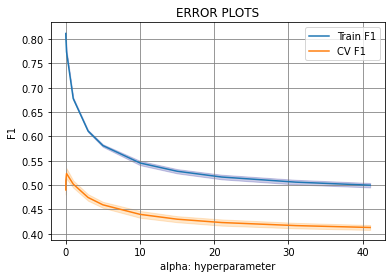

Predictions using test data: 
Prediction accuracy:   0.597
classification report:
              precision    recall  f1-score   support

         ALG       0.67      0.53      0.59       200
         BAG       0.76      0.79      0.77       200
         BEI       0.48      0.48      0.48       200
         FES       0.43      0.52      0.47       200
         MOS       0.45      0.55      0.50       200
         RAB       0.69      0.56      0.62       200
         DAM       0.65      0.59      0.62       200
         SFX       0.70      0.60      0.65       200
         JED       0.62      0.67      0.64       200
         MSA       0.48      0.35      0.41       200
         BAS       0.53      0.53      0.53       200
         KHA       0.59      0.56      0.58       200
         DOH       0.68      0.71      0.69       200
         JER       0.53      0.54      0.53       200
         ASW       0.44      0.52      0.47       200
         MUS       0.57      0.69      0.63       200

array([23, 17, 17, ..., 24, 14, 24])

In [41]:
gridsearch_NB(X_train_tfidf_char_wb, X_train['dialect'], X_cv_tfidf_char_wb, X_cv['dialect'])

In [42]:
evaluate(pred, 'NB-3', 'NB: Character-gram features with word boundary consideration, from bi-gram and up to 5-gram')

Evaluation (Task 4):


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 59.11 %
MACRO AVERAGE RECALL SCORE: 58.38 %
MACRO AVERAGE F1 SCORE: 58.43 %
OVERALL ACCURACY: 58.38 %



### 2- LSTM Deep Network (20%)
Use the Long Short Term Memory (LSTM) architecture with AraVec pre-trained word embeddings models.

**Note: the code assumes that the Twitter CBOW is downloaded to the folder below. Otherwise please uncomment the code to download, but this will download 1GB+ file**

In [43]:
# Download via terminal commands, requires patoolib to extract
aravec =  'full_grams_cbow_100_twitter.zip'
'''
if aravec not in os.listdir():
  !curl --header 'Host: bakrianoo.s3-us-west-2.amazonaws.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:82.0) Gecko/20100101 Firefox/82.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://github.com/bakrianoo/aravec' --header 'Upgrade-Insecure-Requests: 1' 'https://bakrianoo.s3-us-west-2.amazonaws.com/aravec/full_grams_cbow_100_twitter.zip' --output 'full_grams_cbow_100_twitter.zip'
  patoolib.extract_archive('full_grams_cbow_100_twitter.zip',outdir= '/cbow')
'''

"\nif aravec not in os.listdir():\n  !curl --header 'Host: bakrianoo.s3-us-west-2.amazonaws.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:82.0) Gecko/20100101 Firefox/82.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://github.com/bakrianoo/aravec' --header 'Upgrade-Insecure-Requests: 1' 'https://bakrianoo.s3-us-west-2.amazonaws.com/aravec/full_grams_cbow_100_twitter.zip' --output 'full_grams_cbow_100_twitter.zip'\n  patoolib.extract_archive('full_grams_cbow_100_twitter.zip',outdir= '/cbow')\n"

In [45]:
# load the AraVec model
cbow_folder = './cbow/'
model = gensim.models.Word2Vec.load(cbow_folder + 'full_grams_cbow_100_twitter.mdl')
print('We have',len(model.wv.index2word),'vocabularies')

We have 1476715 vocabularies


In [46]:
X_train.head()

,sentence,dialect
0,هناك ، امام بيانات الساءح تماما .,17
1,لم اسمع بهذا العنوان من قبل بالقرب من هنا .,17
2,استمر في السير في هذا الطريق حتي تجد صيدليه .,17
3,كم تكلفه الافطار ؟,17
4,كيف استطيع مساعدتك ؟,17


In [48]:
y_train = tf.keras.utils.to_categorical(X_train['dialect'],  dtype='float32')
y_cv = tf.keras.utils.to_categorical(X_cv['dialect'], dtype='float32')

In [49]:
print(y_train.shape)

(41600, 26)


In [50]:

tf.keras.backend.clear_session()
#Using Camet Tools tokeniser
token = Tokenizer(char_level=False, analyzer=simple_word_tokenize)
token.fit_on_texts(X_train['sentence'])
vocab_size_essay = len(token.word_index) + 1

print(vocab_size_essay)

encoded_docs = token.texts_to_sequences(X_train['sentence'])
padded_docs = pad_sequences(encoded_docs, padding='post')
max_len_essay = padded_docs.shape[1]

print(padded_docs.shape)

encoded_docs_test = token.texts_to_sequences(X_cv['sentence'])
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len_essay, padding='post')

print(padded_docs_test.shape)

24659
(41600, 46)
(5200, 46)


In [51]:
padded_docs[0]

array([   57,     3,  3660,  8958, 12388,  2293,     1,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [52]:
padded_docs_test[0]

array([1821,    3,  319,    1,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [53]:
trained_words =  list(model.wv.vocab)
j = 0
embedding_matrix = np.zeros((vocab_size_essay, 100))
for word, i in tqdm(token.word_index.items()):
  if word in trained_words:
    embedding_vector =  model.wv[word]
    j += 1
    embedding_matrix[i] = embedding_vector
print(j)

100%|██████████| 24658/24658 [04:20<00:00, 94.60it/s] 

19753


In [54]:
print(embedding_matrix.shape)
print(vocab_size_essay)

(24659, 100)
24659


In [55]:
%load_ext tensorboard

In [56]:
input_layer = Input(shape=(max_len_essay,))
emb_essay = Embedding(vocab_size_essay, 100, weights=[embedding_matrix], 
                      input_length=max_len_essay, trainable=True)(input_layer)

lstm_essay = Bidirectional(LSTM(100))(emb_essay)
flatten1 = Flatten()(lstm_essay)
dense = Dense(units = 1024,activation='relu',kernel_initializer='he_normal')(flatten1)
dropout= Dropout(0.1)(dense)

for i in range(2):
        dense = Dense(units = int(512/(i+1)),activation='relu',kernel_initializer='he_normal')(dropout)
        dense  = BatchNormalization()(dense)
        dropout= Dropout(0.1)(dense)
  
dense = Dense(units = 128,activation='relu',kernel_initializer='he_normal')(dropout)
bn_layer  = BatchNormalization()(dense)

dense = Dense(units = 64,activation='relu',kernel_initializer='he_normal')(bn_layer)
outputs = Dense(26,activation='softmax')(dense)

model1 = tf.keras.Model(inputs=[input_layer], outputs=outputs)

print(model1.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 46, 100)           2465900   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 26)                5226      
Total params: 2,631,926
Trainable params: 2,631,926
Non-trainable params: 0
____________________________________________

In [57]:
def f1_score_micro(y_true,y_pred):
      return f1_score(y_true,y_pred,average = 'micro')


In [58]:
def micro_f1(y_true, y_proba):
      y_pred = tf.math.argmax(y_proba,axis=-1)
      y_true = tf.math.argmax(y_true,axis=-1)
      return tf.py_function(f1_score_micro,(y_true,y_pred),tf.double)

Epoch 1/100
163/163 [==============================] - 8s 48ms/step - loss: 3.1976 - accuracy: 0.0756 - val_loss: 2.9802 - val_accuracy: 0.1335
Epoch 2/100
163/163 [==============================] - 7s 41ms/step - loss: 2.8859 - accuracy: 0.1445 - val_loss: 2.7209 - val_accuracy: 0.1854
Epoch 3/100
163/163 [==============================] - 7s 42ms/step - loss: 2.6585 - accuracy: 0.1884 - val_loss: 2.5147 - val_accuracy: 0.2346
Epoch 4/100
163/163 [==============================] - 7s 43ms/step - loss: 2.4868 - accuracy: 0.2225 - val_loss: 2.3703 - val_accuracy: 0.2698
Epoch 5/100
163/163 [==============================] - 7s 41ms/step - loss: 2.3642 - accuracy: 0.2513 - val_loss: 2.2716 - val_accuracy: 0.2927
Epoch 6/100
163/163 [==============================] - 7s 41ms/step - loss: 2.2702 - accuracy: 0.2718 - val_loss: 2.1914 - val_accuracy: 0.3135
Epoch 7/100
163/163 [==============================] - 7s 41ms/step - loss: 2.1895 - accuracy: 0.2929 - val_loss: 2.1262 - val_accuracy:

163/163 [==============================] - 6s 37ms/step - loss: 1.1882 - accuracy: 0.5857 - val_loss: 1.7414 - val_accuracy: 0.4610
Epoch 57/100
163/163 [==============================] - 6s 38ms/step - loss: 1.1889 - accuracy: 0.5848 - val_loss: 1.7406 - val_accuracy: 0.4615
Epoch 58/100
163/163 [==============================] - 7s 42ms/step - loss: 1.1857 - accuracy: 0.5871 - val_loss: 1.7339 - val_accuracy: 0.4650
Epoch 59/100
163/163 [==============================] - 6s 38ms/step - loss: 1.1855 - accuracy: 0.5876 - val_loss: 1.7463 - val_accuracy: 0.4602
Epoch 60/100
163/163 [==============================] - 6s 37ms/step - loss: 1.1806 - accuracy: 0.5888 - val_loss: 1.7501 - val_accuracy: 0.4598
Epoch 00060: early stopping


Min Val Loss:  1.697509765625
Max Val Accuracy:  0.4650000035762787




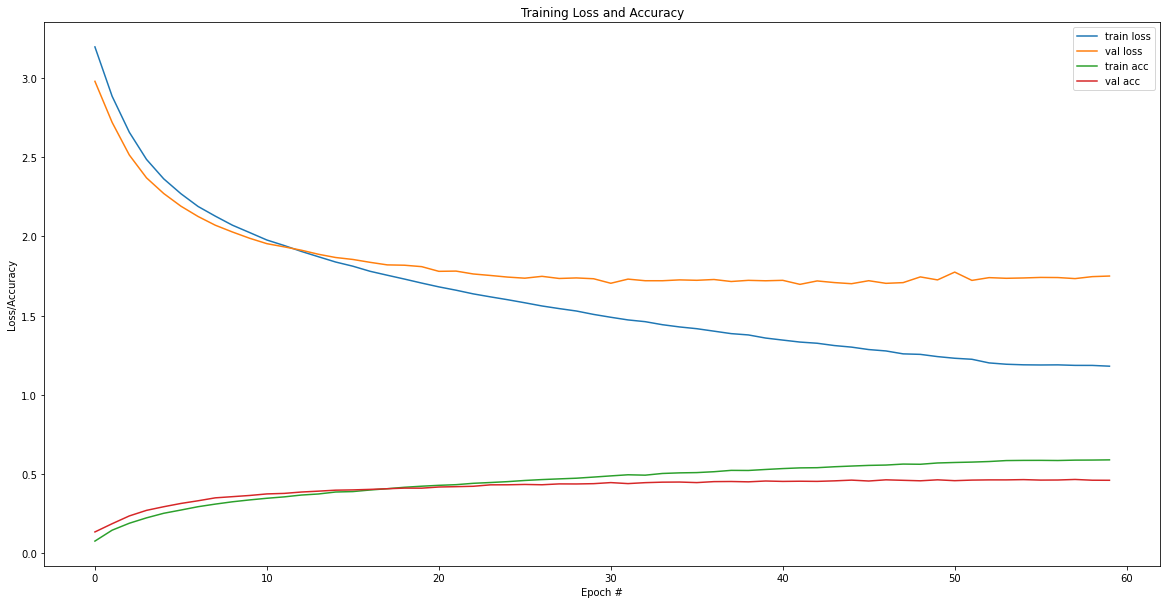

(1.697509765625, 0.4650000035762787)

In [59]:
'''
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
               loss='categorical_crossentropy',metrics=['accuracy',micro_f1])
              '''
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model1.compile(optimizer=opt, 
               loss='categorical_crossentropy',metrics=['accuracy'])



reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5,mode='min',verbose=1)
EarlyStopping1 = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=15, verbose=1, mode='min')


execute_model(model1, padded_docs, y_train, padded_docs_test, y_cv)

In [60]:
model = load_model(model1, 'model1')
#Come back from Softmax to classes
pred = np.argmax(model.predict(padded_docs_test), axis = 1)
evaluate(pred, 'LTSM', 'LTSM')

Evaluation (Task 4):


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 47.25 %
MACRO AVERAGE RECALL SCORE: 46.50 %
MACRO AVERAGE F1 SCORE: 46.53 %
OVERALL ACCURACY: 46.50 %



### 3- BERT for Dialectal Arabic (20%)

BERT1 or Bidirectional Encoder Representations from Transformers (BERT), has recently
been introduced by Google AI Language researchers (Devlin et al., 2018). It replaces the
sequential nature of RNN (LSTM & GRU) with a much faster Attention-based approach. The
model is also pre-trained on two unsupervised tasks, masked language modeling and next
sentence prediction. This allows you to use a pre-trained BERT model by fine-tuning the same
on downstream specific tasks such as Dialectal Arabic classification.
You can employ the multi-lingual BERT that has been pre-trained on MSA and then fine tune
it for dialectal Arabic.
I recommend to read the following Blog Multi-label Text Classification using BERT
https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mightytransformer-
69714fa3fb3d

In [61]:
text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessing = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1')
encoder_inputs = preprocessing(text_inputs)
#BERT Multilingual cased
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3', trainable=False)
output = bert_layer(encoder_inputs)

#Bert model
#I am using only pooled output not sequence out. 
#Please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=text_inputs, outputs=output['pooled_output'])

In [62]:
X_train_pooled_output = bert_model.predict(X_train['sentence'])
X_test_pooled_output =bert_model.predict(X_cv['sentence'])

In [63]:
input_layer = Input(shape=(X_train_pooled_output.shape[1],))

x = Dense(1024,activation = 'relu')(input_layer)
x = Dense(512,activation = 'relu')(x)
x = Dense(256,activation = 'relu')(x)
x = Dropout(.1)(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(.1)(x)
x = Dense(64,activation = 'relu')(x)
x  = BatchNormalization()(x)
output_layer = Dense(26,activation = 'softmax')(x)
model2 = Model(inputs = input_layer,outputs = output_layer)
model2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              787456    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [64]:

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                    loss='categorical_crossentropy',metrics=['accuracy'])

reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5,mode='min',verbose=1)
early_stopping2 = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')


Epoch 1/100
163/163 [==============================] - 2s 9ms/step - loss: 3.3035 - accuracy: 0.0488 - val_loss: 3.2546 - val_accuracy: 0.0588
Epoch 2/100
163/163 [==============================] - 1s 7ms/step - loss: 3.2217 - accuracy: 0.0661 - val_loss: 3.2365 - val_accuracy: 0.0738
Epoch 3/100
163/163 [==============================] - 1s 8ms/step - loss: 3.1743 - accuracy: 0.0817 - val_loss: 3.1893 - val_accuracy: 0.0815
Epoch 4/100
163/163 [==============================] - 2s 14ms/step - loss: 3.1281 - accuracy: 0.0933 - val_loss: 3.1199 - val_accuracy: 0.0873
Epoch 5/100
163/163 [==============================] - 1s 6ms/step - loss: 3.0798 - accuracy: 0.1033 - val_loss: 3.2118 - val_accuracy: 0.0815
Epoch 6/100
163/163 [==============================] - 1s 7ms/step - loss: 3.0317 - accuracy: 0.1135 - val_loss: 3.0463 - val_accuracy: 0.1188
Epoch 7/100
163/163 [==============================] - 1s 6ms/step - loss: 2.9870 - accuracy: 0.1254 - val_loss: 3.1010 - val_accuracy: 0.107

Epoch 57/100
158/163 [============================>.] - ETA: 0s - loss: 2.3759 - accuracy: 0.2665
Epoch 00057: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
163/163 [==============================] - 1s 6ms/step - loss: 2.3764 - accuracy: 0.2667 - val_loss: 2.5738 - val_accuracy: 0.2271
Epoch 58/100
163/163 [==============================] - 1s 6ms/step - loss: 2.3623 - accuracy: 0.2723 - val_loss: 2.5661 - val_accuracy: 0.2317
Epoch 59/100
163/163 [==============================] - 1s 6ms/step - loss: 2.3615 - accuracy: 0.2736 - val_loss: 2.5657 - val_accuracy: 0.2313
Epoch 60/100
163/163 [==============================] - 1s 6ms/step - loss: 2.3580 - accuracy: 0.2727 - val_loss: 2.5655 - val_accuracy: 0.2321
Epoch 61/100
163/163 [==============================] - 1s 6ms/step - loss: 2.3608 - accuracy: 0.2733 - val_loss: 2.5652 - val_accuracy: 0.2333
Epoch 62/100
163/163 [==============================] - 1s 6ms/step - loss: 2.3583 - accuracy: 0.2739 - val_loss: 2

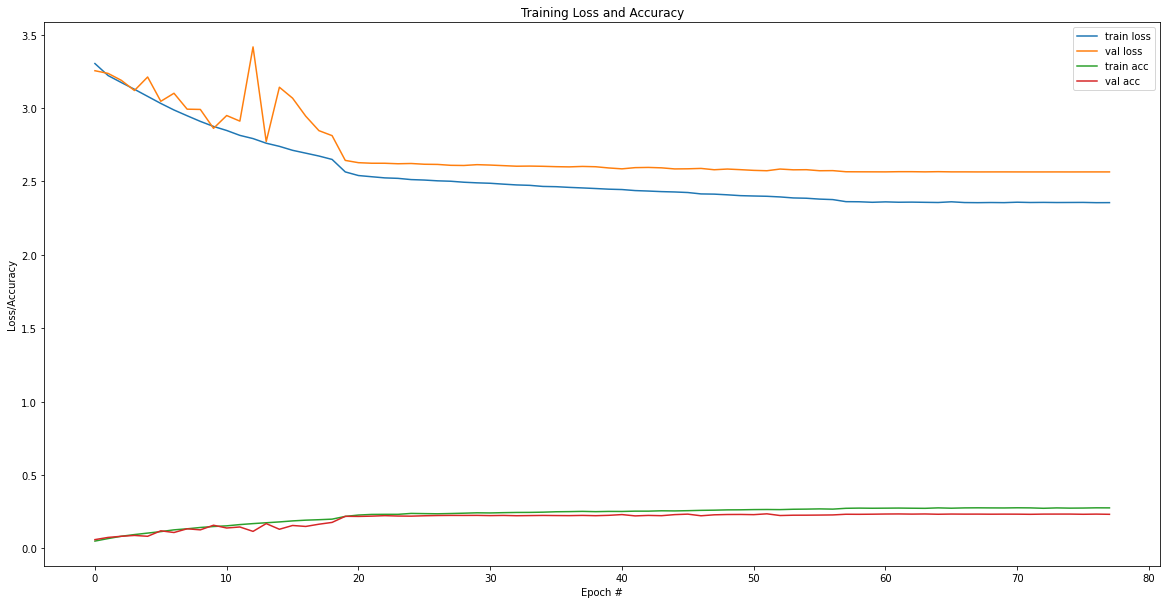

(2.5648224353790283, 0.23461538553237915)

In [65]:

execute_model(model2, X_train_pooled_output, y_train, X_test_pooled_output, y_cv,
              'model2', reduce_lr2, early_stopping2 )

In [69]:
model2 = load_model(model2, 'model2')
#Come back from Softmax to classes
pred = np.argmax(model2.predict(X_test_pooled_output), axis = 1)
evaluate(pred, 'BERT', 'BERT')

Evaluation (Task 4):


OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 22.67 %
MACRO AVERAGE RECALL SCORE: 23.46 %
MACRO AVERAGE F1 SCORE: 22.02 %
OVERALL ACCURACY: 23.46 %



### 4 - Evaluation (10%)

In [67]:
print('Summary of eveluations: \n\n')
for file, description in file_list:
    print(description + ':')
    execute_evaluation(file)
    print('\n')
    
    

Summary of eveluations: 


KNN: Word-gram features with uni-gram, bi-gram and tri-gram:

OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 49.42 %
MACRO AVERAGE RECALL SCORE: 47.48 %
MACRO AVERAGE F1 SCORE: 47.53 %
OVERALL ACCURACY: 47.48 %



KNN: Character-gram features without word boundary consideration, from bi-gram and up to 5-gram:

OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 47.99 %
MACRO AVERAGE RECALL SCORE: 45.50 %
MACRO AVERAGE F1 SCORE: 45.39 %
OVERALL ACCURACY: 45.50 %



KNN: Character-gram features with word boundary consideration, from bi-gram and up to 5-gram:

OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 48.90 %
MACRO AVERAGE RECALL SCORE: 46.29 %
MACRO AVERAGE F1 SCORE: 46.63 %
OVERALL ACCURACY: 46.29 %



NB: Word-gram features with uni-gram, bi-gram and tri-gram:

OVERALL SCORES:
MACRO AVERAGE PRECISION SCORE: 59.11 %
MACRO AVERAGE RECALL SCORE: 58.38 %
MACRO AVERAGE F1 SCORE: 58.43 %
OVERALL ACCURACY: 58.38 %



NB: Character-gram features without word boundary

# End of submission